In [11]:
##############
#IMPORTS
%reset
import pickle
import numpy as np
import copy 
from sklearn import decomposition
import os
import matplotlib.pyplot as plt
import yaml
from keras import models
from keras import layers
from keras import optimizers
import tensorflow as tf
from helpers import helper_functions

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [12]:
def load_obj(name):
    with open(name+'.pkl', 'rb') as f:
        return pickle.load(f, encoding='latin1')

# Gaussian normalization, return 0 if std is 0
def normalize(obj, mean, std):
    a = obj-mean
    b=std
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

In [13]:
root_dir='/global/cscratch1/sd/al34/autoruns/lookback_with_0d_lookahead/ncomponents_None_lookback_3_prelayers_2_size_10_rnnsize_50_rnndropout_0_recurrentdropout_0_densedropout_0_noised'
input_dir='/global/homes/a/al34/data_files'
model_filename='model.h5'



# load conf file, 'config'
def load_config(config_file):
    with open(config_file) as f:
        config = yaml.load(f)
    return config

config=load_config(os.path.join(root_dir,'conf.yaml'))['data']


In [14]:
###############
#LOAD DATA




# load raw data, 'raw_data'
with open(os.path.join(input_dir,'final_data.pkl'), 'rb') as f: 
        raw_data=pickle.load(f, encoding='latin1')
        

# load processed train data, 'train_data'
with open(os.path.join(input_dir,'train_data.pkl'), 'rb') as f: 
        train_data=pickle.load(f, encoding='latin1')
        
        
# load processed val data, 'val_data'
with open(os.path.join(input_dir,'val_data.pkl'), 'rb') as f: 
        val_data=pickle.load(f, encoding='latin1')

# load processed train target, 'train_target'
with open(os.path.join(input_dir,'train_target.pkl'), 'rb') as f: 
        train_target=pickle.load(f, encoding='latin1')

# load processed val target, 'val_target'
with open(os.path.join(input_dir,'val_target.pkl'), 'rb') as f: 
        val_target=pickle.load(f, encoding='latin1')
        

# load processed shot indices, a dictionary, 'shot_dict'
with open(os.path.join(input_dir,'shot_indices.pkl'), 'rb') as f: 
        shot_dict=pickle.load(f, encoding='latin1')


# load noised model, 'noised_loaded_model'
noised_loaded_model=models.load_model(os.path.join(root_dir,model_filename))

noised_loaded_model.compile(optimizer=optimizers.RMSprop(lr=.001),
                     metrics=['mae'], loss='mse')


# load clean model, 'clean_loaded_model'
clean_root_dir = '/global/cscratch1/sd/al34/autoruns/lookback_with_0d_lookahead/ncomponents_None_lookback_3_prelayers_2_size_10_rnnsize_50_rnndropout_0_recurrentdropout_0_densedropout_0_'

clean_loaded_model = models.load_model(os.path.join(clean_root_dir,model_filename))
clean_loaded_model.compile(optimizer=optimizers.RMSprop(lr=.001),
                     metrics=['mae'], loss='mse')


# load process true train times, 'train_real_times'
with open(os.path.join(input_dir,'train_time.pkl'), 'rb') as f: 
        train_real_times=pickle.load(f, encoding='latin1')
        
# load process true val times, 'val_real_times'
with open(os.path.join(input_dir,'val_time.pkl'), 'rb') as f: 
        val_real_times=pickle.load(f, encoding='latin1')
        
        
# load standard rho points, 'rho_points'
with open(os.path.join(input_dir,'rho_standard.pkl'), 'rb') as f: 
        rho_points=pickle.load(f, encoding='latin1')
  

# load means and standard deviations of data
means = helper_functions.load_obj(input_dir+'/means')
stds = helper_functions.load_obj(input_dir+'/stds')

In [15]:
#################
#Data organization

#list of all the shots in sorted number, 'train_shot_nums'
train_shot_nums = shot_dict['train_shot_names']

#list of all the shots in sorted number, 'val_shot_nums'
val_shot_nums = shot_dict['val_shot_names']

# list of the indices where each shot begins in the data, 'train_shot_indices'
train_shot_indices = shot_dict['train_shot_indices']

# list of the indices where each shot begins in the data, 'val_shot_indices'
val_shot_indices = shot_dict['val_shot_indices']


# list of 0D and 1D signals, 'sig_keys_0d' and 'sig_keys_1d'
sig_keys_0d = config['sigs_0d'] #['curr_target', 'pinj']
sig_keys_1d = config['sigs_1d'] #['e_temp']

print(sig_keys_0d)
all_sigs = sig_keys_0d+sig_keys_1d




# delay and lookback values
delay = config['delay']
lookback = config['lookback']






['curr_target', 'pinj']


In [16]:
# read in noisy data

noised_input_dir = '/global/homes/a/al34/noised_data_files'

# load processed train data, 'train_data'
with open(os.path.join(noised_input_dir,'train_data.pkl'), 'rb') as f: 
        noised_train_data=pickle.load(f, encoding='latin1')
        
        
# load processed val data, 'val_data'
with open(os.path.join(noised_input_dir,'val_data.pkl'), 'rb') as f: 
        noised_val_data=pickle.load(f, encoding='latin1')

# load processed train target, 'train_target'
with open(os.path.join(noised_input_dir,'train_target.pkl'), 'rb') as f: 
        noised_train_target=pickle.load(f, encoding='latin1')

# load processed val target, 'val_target'
with open(os.path.join(noised_input_dir,'val_target.pkl'), 'rb') as f: 
        noised_val_target=pickle.load(f, encoding='latin1')
        

# load processed shot indices, a dictionary, 'shot_dict'
with open(os.path.join(noised_input_dir,'shot_indices.pkl'), 'rb') as f: 
        noised_shot_dict=pickle.load(f, encoding='latin1')




# load process true train times, 'train_real_times'
with open(os.path.join(noised_input_dir,'train_time.pkl'), 'rb') as f: 
        noised_train_real_times=pickle.load(f, encoding='latin1')
        
# load process true val times, 'val_real_times'
with open(os.path.join(noised_input_dir,'val_time.pkl'), 'rb') as f: 
        noised_val_real_times=pickle.load(f, encoding='latin1')
        
        
# load standard rho points, 'rho_points'
with open(os.path.join(noised_input_dir,'rho_standard.pkl'), 'rb') as f: 
        noised_rho_points=pickle.load(f, encoding='latin1')
  

# load means and standard deviations of data
noised_means = helper_functions.load_obj(noised_input_dir+'/means')
noised_stds = helper_functions.load_obj(noised_input_dir+'/stds')

7459


Text(0, 0.5, 'e_temp')

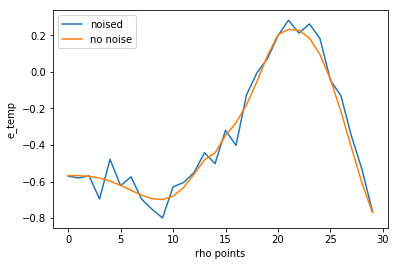

In [17]:

# example of what noised data does on random profiles
noised_train_data.shape == train_data.shape
ts = np.random.choice(10000)
print(ts)
plt.plot( noised_train_data[ts, 1, 2:], label = "noised")
plt.plot( train_data[ts, 1, 2:], label = "no noise")
plt.legend(loc = "best")
plt.xlabel("rho points")
plt.ylabel("e_temp")


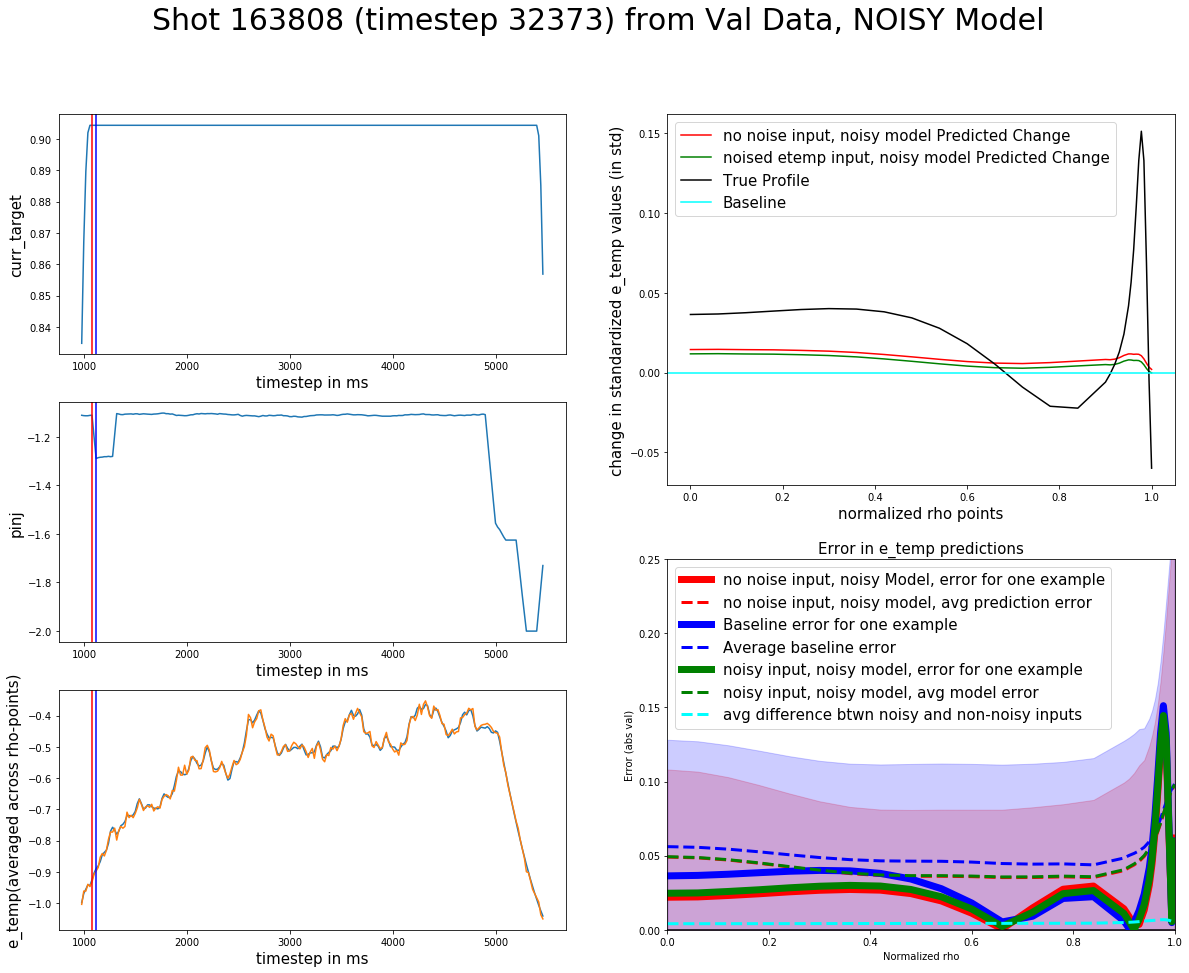

In [69]:
# global and random examples of noised vs no noise model predictions


def noise(timestep, train):
    titlesize = 15
    
    if train:
        shot_indices = train_shot_indices
        data = train_data
        real_times = train_real_times
        shot_nums = train_shot_nums
        target = train_target
        
        noised_data = noised_train_data
        
    else:
        shot_indices = val_shot_indices
        data = val_data
        real_times = val_real_times
        shot_nums = val_shot_nums
        target = val_target
        
        noised_data = noised_val_data
    
    # shot index of timestep 
    shot_index = np.searchsorted(shot_indices, timestep, side='right')-1
    # range of times for that timestep's shot
    timestep_range = list(range(shot_indices[shot_index], shot_indices[shot_index+1]))
    fig = plt.figure(figsize = (20,15))
    
    # plot entire shot history for each 0D sig, with a vertical line symbolizing location 
    # of timestep of interest
    for i in range(len(sig_keys_0d)):
        plot_position = '{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*i+1) 
        tmp_fig = fig.add_subplot(plot_position)
        # get the sig data from the processed data, (which has been shortened by smoothing/lookback)
        sig_data = np.ndarray.flatten(data[timestep_range, lookback, i])
        #joe's version below
        #sig_data=np.array(data)[timestep_range,-delay-1,i].T
        
        
        time_data = real_times[timestep_range]
        
        tmp_fig.plot(time_data, sig_data)
        tmp_fig.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)
        tmp_fig.axvline(real_times[timestep],color='r')
        tmp_fig.axvline(real_times[timestep+delay],color='b')
        
        
    # plot entire shot history for each 1D sig (averaged rho's for each timestep), with a vertical line symbolizing location 
    # of timestep of interest    
    for i in range(len(sig_keys_1d)):
        plot_position = '{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*(len(sig_keys_0d)+i)+1) 
        tmp_fig = fig.add_subplot(plot_position)
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        sig_data = (data[timestep_range, lookback,len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in])
        # average the rho-values across each timestep
        sig_data = (np.mean(sig_data, axis = 1))
        
        
        noised_sig_data = (noised_data[timestep_range, lookback,len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in])
        # average the rho-values across each timestep
        noised_sig_data = (np.mean(noised_sig_data, axis = 1))
        
        
        time_data = real_times[timestep_range]
        tmp_fig.plot(time_data, sig_data)
        tmp_fig.plot(time_data, noised_sig_data)

        tmp_fig.axvline(real_times[timestep],color='r')
        tmp_fig.axvline(real_times[timestep+delay],color='b')
        tmp_fig.set_ylabel(sig_keys_1d[i] + "(averaged across rho-points)", fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)


    
    ##############################################################
    # snapshot noise work
    #plot the prediction profile, the true profile, and the baseline profile
    
    # input_data represents the training data slice for that particular timestep: shape (1, 6, 4)
    input_data=np.array(data)[timestep:timestep+1]
    
    predicted_profile = np.ndarray.flatten(noised_loaded_model.predict(input_data))   
    
    true_profile = target[timestep]
    
    

    
    plot_position = 222
    tmp_fig = fig.add_subplot(plot_position)
    # plot predicted
    tmp_fig.plot(rho_points, predicted_profile, label = "no noise input, noisy model Predicted Change", color = 'r')
    
    # add noised and predict
    noised_input_data=np.array(noised_data)[timestep:timestep+1]
    
    noised_predicted_profile = np.ndarray.flatten(noised_loaded_model.predict(noised_input_data))  
    tmp_fig.plot(rho_points, noised_predicted_profile, label = "noised etemp input, noisy model Predicted Change", color = 'green')


  
    
    # add baseline and true target
    # plot true
    tmp_fig.plot(rho_points, true_profile, label = "True Profile", color = 'black')
    # plot baseline (no change)
    tmp_fig.axhline(0,label='Baseline', color='cyan')
    tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)
    tmp_fig.set_ylabel("change in standardized e_temp values (in std)", fontsize=titlesize)
    


    tmp_fig.legend(loc = "best", fontsize=15)
    
#########################################################################################
    # print title out 
    if train:
        data_type = "Train"
    else:
        data_type = "Val"
    fig.suptitle('Shot {} (timestep {}) from {} Data, NOISY Model'.format(shot_nums[shot_index],timestep, data_type), fontsize = 30)
       
    
    
    #=====================================================================================
    # global and snapshot error work 
    predicted_error = abs(true_profile - predicted_profile)
    baseline_error = abs(true_profile)
    noised_error = abs(true_profile - noised_predicted_profile)
    
    val_mae = abs(noised_loaded_model.predict(data)-target)
    avg_val_mae=np.mean(val_mae, axis=0)
    std_val_mae=np.std(val_mae, axis=0)


    
    baseline_mae=abs(target)
    avg_baseline_mae=np.mean(baseline_mae, axis=0)
    std_baseline_mae=np.std(baseline_mae, axis=0)
    
    noised_mae = abs(noised_loaded_model.predict(noised_data)-target)
    avg_noised_mae=np.mean(noised_mae, axis=0)

    
    difference = abs(noised_loaded_model.predict(noised_data)-noised_loaded_model.predict(data))
    avg_difference=np.mean(difference, axis=0)
    
    
    
    
    
    
    # plot predicted, 
    ax = fig.add_subplot('224')
    ax.set_title('Error in e_temp predictions', fontsize=titlesize)
    ax.plot(rho_points, predicted_error, color='red', label='no noise input, noisy Model, error for one example', linewidth=7)
    ax.plot(rho_points, avg_val_mae, color='red', linestyle='--', label='no noise input, noisy model, avg prediction error', linewidth=3)
    ax.fill_between(rho_points,avg_val_mae-std_val_mae, avg_val_mae+std_val_mae, color='red', alpha=.2)
    ax.axhline(0,color='k')
    ax.plot(rho_points, baseline_error, color='b', label='Baseline error for one example', linewidth=7)
    ax.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline error', linewidth=3)
    ax.fill_between(rho_points,avg_baseline_mae-std_baseline_mae, avg_baseline_mae+std_baseline_mae, color='blue', alpha=.2)
    
    
    ax.plot(rho_points, noised_error, color='green', label='noisy input, noisy model, error for one example', linewidth=7)
    ax.plot(rho_points, avg_noised_mae, color='green', linestyle='--', label='noisy input, noisy model, avg model error', linewidth=3)
    
    ax.plot(rho_points, avg_difference, color='cyan', linestyle='--', label='avg difference btwn noisy and non-noisy inputs', linewidth=3)


    ax.set_ylim(0,.25)
    ax.set_xlim(0,1)
    ax.legend(loc='upper left', fontsize=15)
    ax.set_ylabel('Error (abs val)', fontsize=10)
    ax.set_xlabel('Normalized rho', fontsize=10)
        
    
    

    
    

    
# timestep = np.random.choice(train_shot_indices)
timestep = np.random.choice(val_shot_indices) + 5
#timestep = 8467

noise(timestep, False)


#good shots
#8467

#difference 30163


In [31]:
data = val_data
target = val_target
noised_data = noised_val_data





noised_model_no_noise_input_mae = np.mean(abs(noised_loaded_model.predict(data)-target), axis = 0)

noised_model_noised_input_mae = np.mean(abs(noised_loaded_model.predict(noised_data)-target), axis = 0)


no_noise_model_no_noise_input_mae = np.mean(abs(clean_loaded_model.predict(data)-target), axis = 0)
no_noise_model_noised_input_mae = np.mean(abs(clean_loaded_model.predict(noised_data)-target), axis = 0)



In [56]:
noised_model_no_noise_input_mse= np.mean(np.square((noised_loaded_model.predict(data)-target)), axis=0)

noised_model_noised_input_mse = np.mean(np.square(noised_loaded_model.predict(noised_data)-target), axis = 0)


no_noise_model_no_noise_input_mse = np.mean(np.square(clean_loaded_model.predict(data)-target), axis = 0)
no_noise_model_noised_input_mse = np.mean(np.square(clean_loaded_model.predict(noised_data)-target), axis = 0)

(0.034, 0.05)

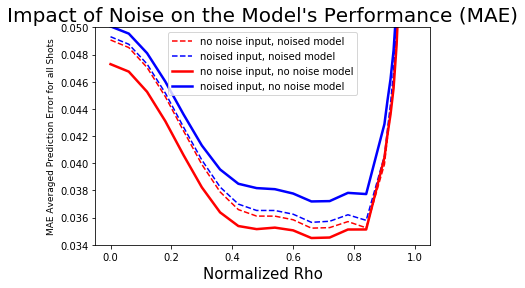

In [52]:

plt.plot(rho_points, noised_model_no_noise_input_mae, linestyle = "--", label = "no noise input, noised model", color = 'red')
plt.plot(rho_points, noised_model_noised_input_mae, linestyle = "--", label = "noised input, noised model", color = 'blue')

plt.plot(rho_points, no_noise_model_no_noise_input_mae, label = "no noise input, no noise model", color = 'red', linewidth = 2.5)

plt.plot(rho_points, no_noise_model_noised_input_mae, label = "noised input, no noise model", color = 'blue', linewidth = 2.5)
plt.legend(loc = "best")

plt.ylabel("MAE Averaged Prediction Error for all Shots", fontsize = 9)
plt.xlabel("Normalized Rho", fontsize = 15)
plt.title("Impact of Noise on the Model's Performance (MAE)", fontsize = 20)
plt.ylim(0.0340, 0.05)

Text(0.5, 0, 'rho points')

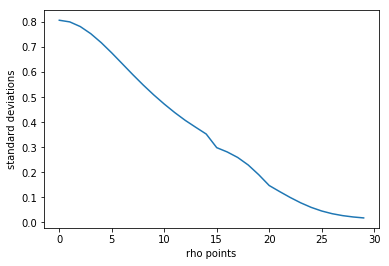

In [66]:
plt.plot(stds['e_temp'])
plt.ylabel("standard deviations")
plt.xlabel("rho points")

(0.002, 0.005)

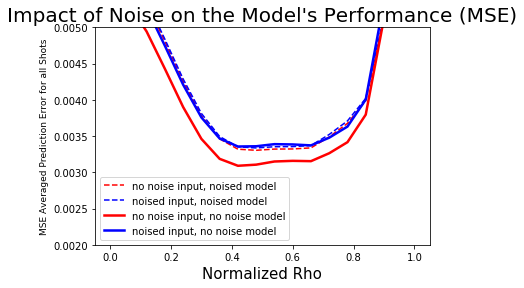

In [61]:

plt.plot(rho_points, noised_model_no_noise_input_mse, linestyle = "--", label = "no noise input, noised model", color = 'red')
plt.plot(rho_points, noised_model_noised_input_mse, linestyle = "--", label = "noised input, noised model", color = 'blue')

plt.plot(rho_points, no_noise_model_no_noise_input_mse, label = "no noise input, no noise model", color = 'red', linewidth = 2.5)

plt.plot(rho_points, no_noise_model_noised_input_mse, label = "noised input, no noise model", color = 'blue', linewidth = 2.5)
plt.legend(loc = "best")

plt.ylabel("MSE Averaged Prediction Error for all Shots", fontsize = 9)
plt.xlabel("Normalized Rho", fontsize = 15)
plt.title("Impact of Noise on the Model's Performance (MSE)", fontsize = 20)
plt.ylim(0.002, 0.005)


In [58]:
noised_model_no_noise_input_mse

array([ 0.00589699,  0.00573768,  0.00533956,  0.00480607,  0.00425653,
        0.00378098,  0.00346169,  0.00331906,  0.00330383,  0.00332059,
        0.00332231,  0.00333702,  0.00348909,  0.00367556,  0.0039855 ,
        0.00512034,  0.00536149,  0.00575735,  0.00632263,  0.00667645,
        0.00780572,  0.00872615,  0.00996407,  0.01172357,  0.0143205 ,
        0.01802779,  0.02291869,  0.02882908,  0.03572786,  0.0436115 ])

In [65]:
load_config(os.path.join(root_dir,'conf.yaml'))

{'data': {'avg_window': 10,
  'delay': 2,
  'input_dir_name': '/global/homes/a/al34/data_files/',
  'lookback': 3,
  'n_components': None,
  'name': 'lstm_cnn',
  'noised_signal': 'e_temp',
  'preprocess': True,
  'sigs_0d': ['curr_target', 'pinj'],
  'sigs_1d': ['e_temp'],
  'sigs_predict': ['e_temp'],
  'train_frac': 0.7,
  'val_frac': 0.2},
 'description': 'LSTM_CNN_MERGE',
 'model': {'cnn_activation': 'linear',
  'cnn_padding': 'same',
  'dense_cnn_activation': 'relu',
  'dense_cnn_size': 10,
  'dense_dropout': 0,
  'dense_final_activation': 'relu',
  'dense_final_size': 40,
  'dense_pre_activation': 'relu',
  'dense_pre_size': 10,
  'include_cnn': False,
  'kernel_size': 10,
  'max_pool_size': 2,
  'name': 'lstm_cnn_merge',
  'num_dense_cnn_layers': 0,
  'num_filters': 2,
  'num_final_layers': 0,
  'num_pre_layers': 2,
  'recurrent_dropout': 0,
  'rho_length_out': 30,
  'rnn_activation': 'relu',
  'rnn_dropout': 0,
  'rnn_size': 50,
  'rnn_type': 'LSTM'},
 'optimizer': {'lr': 0.00

In [4]:
a = [1,2,3,4,5]
a[1::2]

[2, 4]